### Comparing methods of accessing DRS files on compute platform

The following run samtools view on the same data - a 15Gb cram file. The file is available via DRS and is a controlled access file. In the examples below

The graph below shows the time required for three different strategies in managing the file and the compute

* Streamed - samtools is provided the URL from DRS - the
* Local - the file is downloaded from the URL provided by DRS and the compute is performed on a local file
* Link - the file is in another workspace on the compute platform

### Caveat up front
There is a missing data point we require for the full picture, but that does not invalidata the analysis. The gap will be mentioned below.


The following data captures the time in seconds required for different steps under each of the three strategies.

* download - download of the file (via DRS provided URL) to platform cloud storage
* transfer - within cloud provider/platform transfer of the file to workspace for the compute task
* tool load - retrieval from tool repository, and tool start up time (vm instantiation)
* compute - running the tool

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/workflow_comparisons.csv")
df

,strategy,download,transfer,tool load,compute
0,streamed,NaN,NaN,11,503
1,local,960.0,164.0,11,285
2,link,NaN,165.0,9,283


<AxesSubplot: title={'center': 'Total time secs'}, xlabel='strategy'>

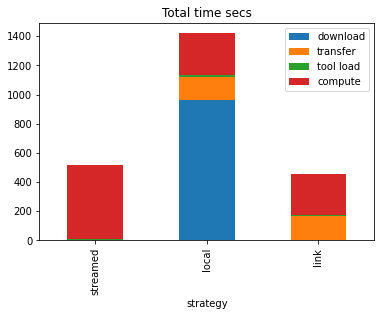

In [4]:
df.plot.bar(x='strategy', stacked=True, title='Total time secs')

### Comparing  streamed vs local
Computing on the file as it is streamed into the compute platform is significantly faster (514s) than downloading the file to local storage and then running the compute (1420s).

A hypothesis for this is that samtools can get on with its compute as soon as it starts receiving data. The compute occurs synchronously with the streaming. 
#### ToDo - validate the above hypothesis with samtools developers/GA4GH LSG team

### Avoiding the download
(The above would incur egress charges, but in the interests of focus am keeping that as a separate discussion. That download costs are incuured through the use of DRS is is explored [here](https://github.com/ga4gh/fasp-scripts/blob/master/notebooks/drs/Check%20SB%20Download%20costs.ipynb))

Excluding the download and replotting:

<AxesSubplot: title={'center': 'Total time secs'}, xlabel='strategy'>

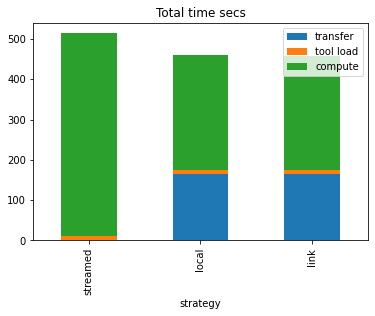

In [5]:
df2 = df[['strategy','transfer','tool load','compute']]
df2.plot.bar(x='strategy', stacked=True, title='Total time secs')

Under the "local" strategy a 164s overhead is incurred in moving the file into the workspace. However, once the file is there the compute takes place faster (282s vs 503s). The net time (once the file is on platform) is slightly faster for local than for streamed. The streaming appears to be the rate-limiting step.

#### ToDo - Probably a can of worms here in how this would apply when threaded/parallel processing is used. Need the opinion of tool developers, and some experimentation.

The link strategy is essentially identical in terms of time taken. In this scenario the file was downloaded to AWS cloud storage in (Seven Bridges BioData Catalyst). The DRS linking capability in Seven Bridges allows certain DRS ids to be added to a user's 'project' and referred to in a workflow.

The observation that the time for 'local' and 'link' is much the same confirms what might be expected; that transfer/copy from another bucket to the compute workspace bucket is no different than for a bucket owned by the platform/user.
However, in this simulation the bucket is not truly a third-party bucket. The cloud platform is presumably using cloud-provider level access to get to the data.  

The missing experiment referred to above is to do this against the true third-party bucket. The NCBI owned AWS bucket. (Note that bucket is already being accessed in the streamed scenario).

#### ToDo - how close to this experiment are we?
The current approach is presumably that the compute platform (Seven Bridges) takes the DRS id and the users Passport (how does it get that?) and calls DRS to get to the file.

If DRS is used cleanly then all the compute platform has access to is the functionality available through the DRS spec. It would be limited to obtaining the signed URL. That puts it in the position of the streamed or download-local scenarios. 

To do the link scenario, and copy across within cloud provider storage, would require being able to access the third party (NCBI) bucket. This is currently not possible/desirable. There are technical for options on how it could possibly addressed which are worth discussion.

### Credits
* Science project - [Undiagnosed Disease Network](https://undiagnosed.hms.harvard.edu/)
* [NIH Common Fund page on UDN](https://commonfund.nih.gov/Diseases)
* Compute platform - Seven Bridges (Cavatica and NCI Cancer Genomics Cloud)
* Compute tool - samtools - samtools developers and GA4GH Large Scale Genomics work stream
* Passport implementation - NCBI/ NIH CIT
* Clearing House - NCBI dbGaP
* Cloud Storage - NCBI managed AWS storage
* Data Access Committee - NHGRI
* Data Access management - NCBI dbGaP
* WES and DRS Protocols - GA4GH Cloud workstream
* Passport - GA4GH Data Use and Researcher Identity workstream
* Secondary Cloud storage for simulation - NHLBI BioDataCatalyst